# import

In [1]:
import pandas as pd
import numpy as np
from openpyxl import Workbook, load_workbook

In [2]:
from sqlalchemy import create_engine

DATABASES = {
    'MIS':{
        'NAME': 'misdw',
        'USER': 'omis',
        'PASSWORD': 'p@ssw0rd',
        'HOST': '10.88.25.36',
        'PORT': 5432,
    },
}

db = DATABASES['MIS']

engine_string = 'postgresql://{user}:{password}@{host}:{port}/{database}'.format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

engine = create_engine(engine_string)
conn = engine.connect()

# pd.read_sql_table("PPMIS_Projects", conn)

In [3]:
def ReadSqlFromFile(filename):
    # Open and read the file as a single buffer
    sql_file = open(r'C:\Users\6506\Desktop\數位大腦\SQL'+'\\'+filename+'.sql',encoding='utf-8')
    sql_text=sql_file.read().encode('utf-8').decode('utf-8-sig')
    sql_file.close()

    # all SQL commands (split on ';')
    # sqlCommands = sqlFile.split(';')
    return pd.read_sql(sql_text,conn)

# ReadSqlFromFile('專案-專案清單')

In [4]:
# pd.read_sql_table("PNPMS_Vendor", conn)

In [5]:
# pd.read_sql('''
# SELECT date_part('year',"Account_YM") FROM "public"."PPCMS_PLStatment_Detail" limit 1
# ''',conn)

# 損益

In [6]:
# 專案清單 = pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\專案.xlsx','專案清單')
專案清單 = ReadSqlFromFile('專案-專案清單+分類')

In [7]:
# 損益總覽 = pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\專案損益.xlsx','損益總覽')

In [8]:
# 損益明細 = pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\專案損益.xlsx','損益明細')
損益明細_month = ReadSqlFromFile('專案損益-損益明細 - 年月')

In [9]:
# 損益明細['年月'].dt.year

In [10]:
# 損益明細_month=損益明細.groupby(['專案成本代碼', '部群', 'Column1', '大項', 'Parent', '中項', 'Type_ID', '細項',損益明細['年月'].dt.year]).sum().reset_index()
損益明細_清單=pd.merge(損益明細_month,專案清單,on=['專案成本代碼'])

In [11]:
# set(損益明細_month['專案成本代碼'].drop_duplicates()).difference(損益明細_清單['專案成本代碼'].drop_duplicates())
# set(損益明細_month['專案成本代碼'].drop_duplicates())-set(損益明細_清單['專案成本代碼'].drop_duplicates())

In [12]:
成本=損益明細_清單['大項']=='成本'
收入=損益明細_清單['大項']=='收入'
# SA專案=(損益明細_清單['專案屬性']!='ASP專案') & (損益明細_清單['結案']=='是')
SA專案=(損益明細_清單['專案分類']=='客製服務') & (損益明細_清單['結案']=='是')

In [13]:
總成本=損益明細_清單[SA專案&成本].groupby(['專案成本代碼'])['金額'].sum().reset_index(name ='總成本')
總收入=損益明細_清單[SA專案&收入].groupby(['專案成本代碼'])['金額'].sum().reset_index(name ='總收入')
損益明細_SA專案=pd.merge(損益明細_清單[SA專案],總成本.merge(總收入,on=['專案成本代碼']),on=['專案成本代碼'],how='left').set_index(損益明細_清單[SA專案].index)

In [14]:
總成本_ASP=損益明細_清單[~SA專案&成本].groupby(['專案成本代碼','年月','細項'])['金額'].sum().reset_index(name ='總成本')
總收入_ASP=損益明細_清單[~SA專案&收入].groupby(['專案成本代碼','年月','細項'])['金額'].sum().reset_index(name ='總收入')
損益明細_ASP專案=pd.merge(損益明細_清單[~SA專案].merge(總成本_ASP,on=['專案成本代碼','年月','細項'],how='left'),總收入_ASP,on=['專案成本代碼','年月','細項'],how='left').set_index(損益明細_清單[~SA專案].index)

In [15]:
final=pd.concat([損益明細_ASP專案,損益明細_SA專案])

In [16]:
final.to_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\數位大腦.xlsx',encoding='ANSI',index=False)
# wb = Workbook(write_only=True)
# wb.save(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\數位大腦.xls')

# SI專案->客製服務

In [16]:
# 損益明細_SI專案=final[final['結案']=='是']
損益明細_SI專案=損益明細_SA專案
委外成本=損益明細_SI專案[損益明細_SI專案['細項']=='建置成本'].groupby(['專案成本代碼'])['金額'].sum().reset_index(name ='委外成本')
委外分析=損益明細_清單[成本].groupby(['專案成本代碼'])['金額'].sum().reset_index(name ='總成本').merge(損益明細_清單[收入].groupby(['專案成本代碼'])['金額'].sum().reset_index(name ='總收入'),on=['專案成本代碼']).merge(委外成本,on=['專案成本代碼'])
委外分析=委外分析[委外分析['總成本']>0]
委外分析['委外比例']=委外分析['委外成本']/委外分析['總成本']*100
委外分析['毛利率']=(委外分析['總收入']-委外分析['總成本'])/委外分析['總收入']*100
委外分析.loc[委外分析['毛利率']<-100,'毛利率']=-100

# 客戶客單價分析

In [17]:
客單價分析 = ReadSqlFromFile('客戶客單價分析')

In [18]:
客戶分析 = 客單價分析.merge(委外分析,on=['專案成本代碼'])

In [19]:
客戶總帳款=客戶分析.groupby(['客戶統編'])['帳款'].sum().reset_index(name ='客戶總帳款')
客戶專案數=客戶分析.groupby(['客戶統編'])['專案成本代碼'].count().reset_index(name ='客戶專案數')

客戶總成本=客戶分析.groupby(['客戶統編'])['總成本'].sum().reset_index(name ='客戶總成本')
客戶總收入=客戶分析.groupby(['客戶統編'])['總收入'].sum().reset_index(name ='客戶總收入')

In [20]:
客單價=客戶專案數.merge(客戶總帳款,on=['客戶統編']).merge(客戶總成本,on=['客戶統編']).merge(客戶總收入,on=['客戶統編'])
客單價['平均淨利']=(客單價['客戶總收入']-客單價['客戶總成本'])/客單價['客戶專案數']
客單價['客單價']=客單價['客戶總帳款']/客單價['客戶專案數']
客單價=客單價[客單價['客戶專案數']>=1]
from sklearn import preprocessing
客單價['平均淨利']=preprocessing.StandardScaler().fit_transform(客單價[['平均淨利']])
客單價['客單價']=preprocessing.StandardScaler().fit_transform(客單價[['客單價']])

In [21]:
客戶清單=客戶分析[['專案成本代碼','客戶統編']][客戶分析['num']==1].merge(客單價,on=['客戶統編'])

In [22]:
客戶統編名稱=客單價.merge(客戶分析[['客戶統編','客戶名稱']].drop_duplicates(),on=['客戶統編'])
客戶統編名稱['客戶統編名稱']=客戶統編名稱['客戶統編']+'/'+客戶統編名稱['客戶名稱']
客戶統編名稱.to_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\客戶清單.xlsx',encoding='ANSI',index=False)

In [23]:
客戶統編名稱

,客戶統編,客戶專案數,客戶總帳款,客戶總成本,客戶總收入,平均淨利,客單價,客戶名稱,客戶統編名稱
0,00003251,1,33500.0,5.732000e+02,0.0,-0.360420,-0.159936,三通報關通運有限公司,00003251/三通報關通運有限公司
1,00133803,1,33500.0,5.732000e+02,0.0,-0.360420,-0.159936,宏昌船務報關股份有限公司,00133803/宏昌船務報關股份有限公司
2,00277104,4,7074444.0,1.825152e+06,6234274.0,-0.202535,0.135691,臺灣港務股份有限公司基隆港務分公司,00277104/臺灣港務股份有限公司基隆港務分公司
3,00462305,1,33500.0,5.732000e+02,0.0,-0.360420,-0.159936,聯和興企業股份有限公司,00462305/聯和興企業股份有限公司
4,00501709,1,75000.0,1.725967e+07,17758517.0,-0.288923,-0.152865,財政部關務署基隆關,00501709/財政部關務署基隆關
...,...,...,...,...,...,...,...,...,...
741,97368283,1,1346000.0,2.599498e+06,1281906.0,-0.548965,0.063687,名佳美股份有限公司,97368283/名佳美股份有限公司
742,97401136,1,18200.0,5.403100e+01,0.0,-0.360346,-0.162543,屴群科技有限公司,97401136/屴群科技有限公司
743,99191115,2,16913339.0,1.034374e+07,16107942.0,0.052265,1.275198,行政院農業委員會屏東農業生物技術園區籌備處,99191115/行政院農業委員會屏東農業生物技術園區籌備處
744,99364404,9,12696100.0,4.187481e+06,7339142.0,-0.310205,0.074707,行政院農業委員會農業金融局,99364404/行政院農業委員會農業金融局


# 迴歸

In [23]:
# 以下是迴歸要用的
#委外分析=委外分析[委外分析['毛利率']>0]
委外分析=委外分析.merge(專案清單[['專案成本代碼','部群','專案規模']],on=['專案成本代碼']).merge(客戶清單,on=['專案成本代碼'])

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
X=委外分析[['委外比例','部群','專案規模','客單價','平均淨利']]
y=委外分析['毛利率']

In [25]:
d=X.dtypes==object
index=d[d==True].index

for i in index:
    dummies=pd.get_dummies(X[i])
    X = pd.concat( [X, dummies], axis = 1 )
    X=X.drop(i,axis=1)

In [26]:
regr = LinearRegression().fit(X, y)
result=pd.DataFrame(regr.coef_,index=X.columns,columns=['coef'])
result.loc['intercept']=regr.intercept_
result

,coef
委外比例,0.168831
客單價,-2.670256
平均淨利,63.318337
其他,5.115578
創保,18.203947
資安,-82.576563
資服,12.312083
通關,25.932330
關港貿,38.465084
電商,-11.630646


In [27]:
import statsmodels.api as sm

# add intercept
# X['intercept']=1
X = sm.add_constant(X)
mod = sm.OLS(y, X)
res = mod.fit()
print (res.conf_int(0.05))
res.params

                0          1
const   -2.689810  28.312232
委外比例    -0.089813   0.427475
客單價     -5.078875  -0.261636
平均淨利    42.646171  83.990504
其他     -12.883350  26.317309
創保     -40.165111  79.775807
資安    -180.129953  18.179629
資服      -4.565594  32.392564
通關       8.617863  46.449600
關港貿      8.031302  72.101669
電商     -32.955853  12.897363
高雄     -33.408339  24.967516
A       -5.815343  21.114796
B       -6.962312  25.696026
C      -23.896349  16.316242
M      -10.610668   9.780030


const    12.811211
委外比例      0.168831
客單價      -2.670256
平均淨利     63.318337
其他        6.716979
創保       19.805348
資安      -80.975162
資服       13.913485
通關       27.533732
關港貿      40.066486
電商      -10.029245
高雄       -4.220412
A         7.649727
B         9.366857
C        -3.790053
M        -0.415319
dtype: float64

In [28]:
# 改成用groupby
委外分群=委外分析.groupby(['部群','專案規模']).mean()[['毛利率']]-委外分析['毛利率'].mean()
委外分群=委外分群.join(委外分析.groupby(['部群','專案規模']).count()[['客戶專案數']]).reset_index()

In [29]:
委外結果=委外分群.merge(result,left_on=['部群'], right_index=True).merge(result,left_on=['專案規模'], right_index=True,suffixes=('_部群', '_專案規模'))#.merge(result,left_on=['專案分類'], right_index=True)
# 委外結果 = 委外結果.rename({'coef': 'coef_專案分類'}, axis=1)
委外結果['coef_委外比例']=-0.35 #result.loc['委外比例'][0]
委外結果['coef_客單價']=result.loc['客單價'][0]
委外結果['coef_平均淨利']=result.loc['平均淨利'][0]
委外結果['intercept']=regr.intercept_+17.5+委外結果['毛利率']
委外結果.rename(columns={'客戶專案數':'專案數'}, inplace=True)
委外結果.to_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\委外分析.xlsx',encoding='ANSI',index=False)

In [30]:
委外結果

,部群,專案規模,毛利率,專案數,coef_部群,coef_專案規模,coef_委外比例,coef_客單價,coef_平均淨利,intercept
0,其他,A,-19.309611,7,5.115578,4.446924,-0.35,-2.670256,63.318337,15.805805
4,創保,A,50.393047,1,18.203947,4.446924,-0.35,-2.670256,63.318337,85.508462
7,資服,A,35.521611,18,12.312083,4.446924,-0.35,-2.670256,63.318337,70.637026
11,通關,A,19.362044,10,25.932330,4.446924,-0.35,-2.670256,63.318337,54.477459
15,關港貿,A,27.967679,6,38.465084,4.446924,-0.35,-2.670256,63.318337,63.083094
19,電商,A,-39.118986,13,-11.630646,4.446924,-0.35,-2.670256,63.318337,-4.003570
23,高雄,A,-42.676370,5,-5.821813,4.446924,-0.35,-2.670256,63.318337,-7.560954
1,其他,B,-65.687078,3,5.115578,6.164054,-0.35,-2.670256,63.318337,-30.571663
8,資服,B,31.842297,16,12.312083,6.164054,-0.35,-2.670256,63.318337,66.957713
12,通關,B,-7.731015,7,25.932330,6.164054,-0.35,-2.670256,63.318337,27.384400


[Text(167.4, 181.2, 'X[0] <= 13.966\nmse = 838.782\nsamples = 129\nvalue = 53.708'),
 Text(83.7, 108.72, 'X[4] <= 0.5\nmse = 536.862\nsamples = 92\nvalue = 65.812'),
 Text(41.85, 36.23999999999998, 'mse = 487.399\nsamples = 68\nvalue = 59.648'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 264.273\nsamples = 24\nvalue = 83.278'),
 Text(251.10000000000002, 108.72, 'X[0] <= 95.629\nmse = 319.343\nsamples = 37\nvalue = 23.611'),
 Text(209.25, 36.23999999999998, 'mse = 370.813\nsamples = 26\nvalue = 28.148'),
 Text(292.95, 36.23999999999998, 'mse = 34.029\nsamples = 11\nvalue = 12.887')]

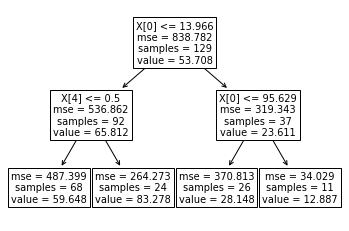

In [224]:
regr_tree = DecisionTreeRegressor(max_depth=2).fit(X, y)
regr_tree.score(X, y)
tree.plot_tree(regr_tree)

In [222]:
regr_forest = RandomForestRegressor(max_depth=2).fit(X, y)
regr_forest.score(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5409198627573021

# proto & ODBC trial

In [ ]:
# 損益明細_清單[~SA專案].groupby(['專案成本代碼','大項','年月'])['金額'].sum().reset_index()

In [ ]:
損益明細_清單.loc[SA專案,'總成本']=損益明細_清單[SA專案&成本].groupby(['專案成本代碼'])['金額'].transform('sum')
# 損益明細_清單[SA專案&成本]['總成本']=損益明細_清單[SA專案&成本].groupby(['專案成本代碼'])['金額'].transform('sum')
損益明細_清單.loc[SA專案,'總收入']=損益明細_清單[SA專案&收入].groupby(['專案成本代碼'])['金額'].transform('sum')

In [ ]:
損益明細_清單[SA專案&收入].groupby(['專案成本代碼'])['金額'].transform('sum')

In [ ]:
# pd.merge(損益明細_清單[SA專案],總成本,on=['專案成本代碼'],how='left').set_index(損益明細_清單[SA專案].index)
# pd.merge(損益明細_清單[SA專案],總收入,on=['專案成本代碼'],how='left').set_index(損益明細_清單[SA專案].index)

In [ ]:
損益明細_清單[SA專案]=pd.merge(損益明細_清單[SA專案],總成本,on=['專案成本代碼','大項'],how='left', left_index=True)

In [ ]:
pd.merge(損益明細_清單[SA專案],總成本,on=['專案成本代碼','大項'],how='left')

In [ ]:
# 專案清單.loc[:,['專案成本代碼','部群','專案屬性']]
專案清單[['專案成本代碼','部群','專案屬性']]

In [ ]:
import pyodbc
pyodbc.drivers()
cnxn = pyodbc.connect('DRIVER={Devart ODBC Driver for PostgreSQL};Server=10.88.25.36;Port=5432;Database=misdw;User ID=omis;Password=p@ssw0rd;charset=utf8;')
conn2 = pyodbc.connect(DRIVER='{Devart ODBC Driver for PostgreSQL}',Server='10.88.25.36',Port='5432',Database='misdw',UID='omis',Password='p@ssw0rd', charset='utf-8')

cnxn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf-8')
cnxn.setencoding(encoding='utf-8')

# 廠商評鑑

In [52]:
# 廠商評鑑要用ASP的毛利率
總成本_ASP=損益明細_清單[~SA專案&成本].groupby(['專案成本代碼'])['金額'].sum().reset_index(name ='總成本')
總收入_ASP=損益明細_清單[~SA專案&收入].groupby(['專案成本代碼'])['金額'].sum().reset_index(name ='總收入')
毛利率_ASP=總成本_ASP.merge(總收入_ASP,on=['專案成本代碼'])
毛利率_ASP['毛利率']=(毛利率_ASP['總收入']-毛利率_ASP['總成本'])/毛利率_ASP['總收入']*100
毛利率_ASP.loc[毛利率_ASP['毛利率']<-100,'毛利率']=-100

委外分析=委外分析[['專案成本代碼','毛利率']].append(毛利率_ASP[['專案成本代碼','毛利率']])

In [10]:
# 專案採購 = pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\專案請購採購.xlsx','專案採購')
# 廠商評鑑 = pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\專案請購採購.xlsx','廠商評鑑')
# 請購作廢止購 = pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\專案請購採購.xlsx','請購作廢止購')
廠商評價分類=pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\廠商評價分類.xlsx')
供應商清單=pd.read_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\供應商清單.xlsx','廠商清單 (優先)')

In [11]:
專案採購 = ReadSqlFromFile('專案請購採購-專案採購')
廠商評鑑 = ReadSqlFromFile('專案請購採購-廠商評鑑')
請購作廢止購 = ReadSqlFromFile('專案請購採購-專案採購-止購')

In [12]:
專案採購_sum=專案採購.groupby(['專案成本代碼','廠商名稱','廠商統編','採購類別'])['採購金額'].sum().reset_index(name ='採購金額')

In [53]:
專案採購_total=專案採購.groupby(['廠商名稱'])['採購金額'].sum().reset_index(name ='總採購金額')

In [54]:
請購作廢止購_count=請購作廢止購.groupby(['成本代號','供應商名稱'])['採購金額'].count().reset_index(name ='作廢止購次數')
請購作廢止購_count.rename(columns={'成本代號':'專案成本代碼'}, inplace=True)
請購作廢止購_count.rename(columns={'供應商名稱':'廠商名稱'}, inplace=True)

In [55]:
廠商評鑑_總覽=廠商評鑑.merge(專案採購_sum,on=['專案成本代碼','廠商名稱','廠商統編']
                   ,how='right').merge(專案採購_total,on=['廠商名稱']
                   ,how='right').merge(請購作廢止購_count,on=['專案成本代碼','廠商名稱']
                   ,how='left').merge(專案清單,on=['專案成本代碼']).merge(廠商評價分類,on=['評鑑意見']
                   ,how='left').merge(供應商清單,on=['廠商名稱','廠商統編'],how='left')

廠商評鑑_總覽['作廢止購次數']=廠商評鑑_總覽['作廢止購次數'].fillna(0)

In [60]:
廠商評鑑_總覽=廠商評鑑_總覽.merge(委外分析[['專案成本代碼','毛利率']],on=['專案成本代碼'],how='left')

In [57]:
廠商評鑑_總覽.to_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\廠商評鑑_總覽.xls',encoding='ANSI',index=False)

In [ ]:
==

In [13]:
廠商金額=專案採購_sum.merge(專案清單,on=['專案成本代碼']).merge(供應商清單,on=['廠商名稱','廠商統編'],how='left')

In [63]:
廠商金額.to_excel(r'C:\Users\6506\Desktop\數位大腦\TABLEAU\廠商金額.xls',encoding='ANSI',index=False)

In [14]:
df = ReadSqlFromFile('廠商評鑑_總覽')
df

,廠商序號,廠商統編,廠商名稱,總採購金額,專案成本代碼,採購金額,評鑑分數,往來建議,評鑑意見,評價,...,是否有預估,是否委外人力,專案開始日,專案結束日,開發開始日,開發結束日,保固開始日,保固結束日,毛利率,毛利率
0,1098,23479270,鼎運企業有限公司,150000,A001,150000,NaN,None,None,None,...,否,是,2008-01-01,2020-12-31,2008-01-01,2020-12-31,None,None,83.316078,0
1,1158,S120852659,高振明,680000,A001,680000,NaN,None,None,None,...,否,是,2008-01-01,2020-12-31,2008-01-01,2020-12-31,None,None,83.316078,0
2,1159,A104282992,黃啟明,440000,A001,440000,NaN,None,None,None,...,否,是,2008-01-01,2020-12-31,2008-01-01,2020-12-31,None,None,83.316078,0
3,1275,P102173796,許堂修,240000,A001,240000,NaN,None,None,None,...,否,是,2008-01-01,2020-12-31,2008-01-01,2020-12-31,None,None,83.316078,0
4,1294,04188141,中華民國關稅協會,82500,A001,82500,NaN,None,None,None,...,否,是,2008-01-01,2020-12-31,2008-01-01,2020-12-31,None,None,83.316078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,1125,55672987,騰森室內裝修工程股份有限公司,12304000,O222,2780000,90.00,列為優先往來對象,如期如質工程,普通,...,是,是,2019-01-01,2019-04-30,2019-01-01,2019-04-30,None,None,-100.000000,0
1813,191,24235506,欣正科技有限公司,9396805,O222,2259640,85.00,列為優先往來對象,配合度高，服務態度佳,好,...,是,是,2019-01-01,2019-04-30,2019-01-01,2019-04-30,None,None,-100.000000,0
1814,273,28853660,鑒真數位有限公司,717050,O228,567050,84.62,列為優先往來對象,目前還在使用中,None,...,是,否,2019-03-12,2020-12-31,2019-03-12,2020-12-31,None,None,-100.000000,0
1815,835,54695999,聯準科技服務有限公司,15345592,O228,225000,NaN,None,None,None,...,是,否,2019-03-12,2020-12-31,2019-03-12,2020-12-31,None,None,-100.000000,0
